# Predictive modeling of customer bookings

#### ML workflow
1) Prepare Data
- Import
- Explore
- Split

2) Build Model

3) Communicate Result

In [1]:
# Import Libraries
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.pipeline import make_pipeline

from catboost import CatBoostClassifier

# To get diferent metric scores
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,roc_auc_score,plot_confusion_matrix,precision_recall_curve,roc_curve,make_scorer




In [2]:
#Import data
df = pd.read_csv("downloads/customer_booking.csv", encoding="ISO-8859-1")
df.head()


,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


## Explore

In [3]:
df.info()
df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

(50000, 14)

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking


In [4]:
df.describe()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


Note that the median of purchase_lead is 51 and the max is 867 (there are outliers present here) and the median of length_of_stay is 17 and the max is 778(present of outliers also here)

In [5]:
# Number of unique classes in each object column
df.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

sales_channel       2
trip_type           3
flight_day          7
route             799
booking_origin    104
dtype: int64

In [6]:
# checkimg for null values
df.isna().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

<AxesSubplot:title={'center':'Class Balance'}, xlabel='Booking', ylabel='Frequency'>

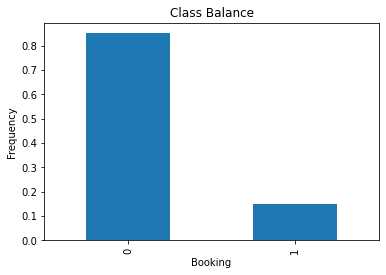

In [7]:
#Class distribution
df["booking_complete"].value_counts(normalize=True).plot(
kind="bar",
xlabel="Booking",
ylabel="Frequency",
title="Class Balance"
)

From the above plot we can see an imbalance, majority of the customers did not complete their booking.

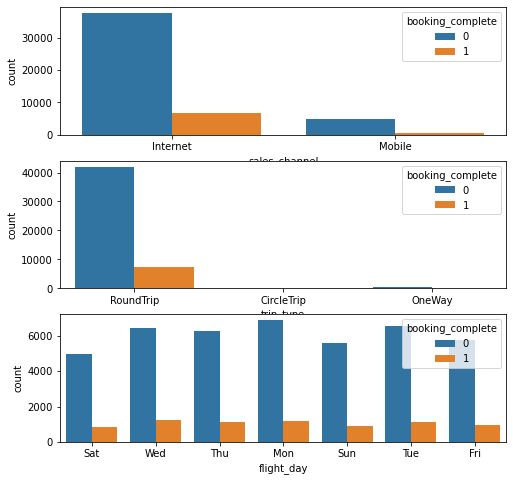

In [8]:
#Using seaborns countplot and subplot
fig, ax = plt.subplots(nrows=3, figsize = [8,8])
#Setting my base color 
base_color = sns.color_palette()[0]
sns.countplot(data = df,x='sales_channel',hue='booking_complete', ax = ax[0])
sns.countplot(data = df,x='trip_type',hue='booking_complete', ax = ax[1])
sns.countplot(data = df,x='flight_day',hue='booking_complete', ax = ax[2])

plt.show()


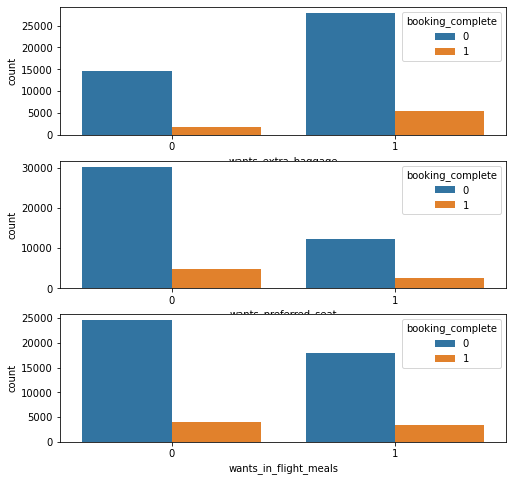

In [9]:
#Using seaborns countplot and subplot
fig, ax = plt.subplots(nrows=3, figsize = [8,8])
#Setting my base color 
base_color = sns.color_palette()[0]
sns.countplot(data = df,x='wants_extra_baggage',hue='booking_complete', ax = ax[0])
sns.countplot(data = df,x='wants_preferred_seat',hue='booking_complete', ax = ax[1])
sns.countplot(data = df,x='wants_in_flight_meals',hue='booking_complete', ax = ax[2])

plt.show()


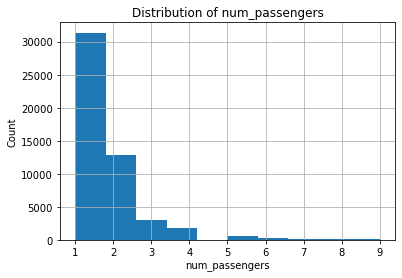

In [10]:
df["num_passengers"].hist()
plt.xlabel("num_passengers")
plt.ylabel("Count"),
plt.title("Distribution of num_passengers");

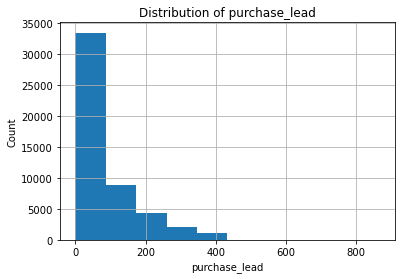

In [11]:
df["purchase_lead"].hist()
plt.xlabel("purchase_lead")
plt.ylabel("Count"),
plt.title("Distribution of purchase_lead");

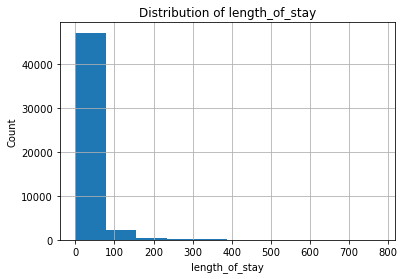

In [12]:
df["length_of_stay"].hist()
plt.xlabel("length_of_stay")
plt.ylabel("Count"),
plt.title("Distribution of length_of_stay");

We can see that distribution of number of passangers, distribution of purchase lead and distribution of length of day are rightly skewed

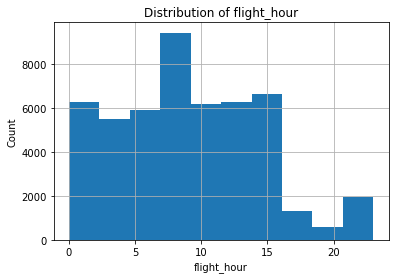

In [13]:
df["flight_hour"].hist()
plt.xlabel("flight_hour")
plt.ylabel("Count"),
plt.title("Distribution of flight_hour");

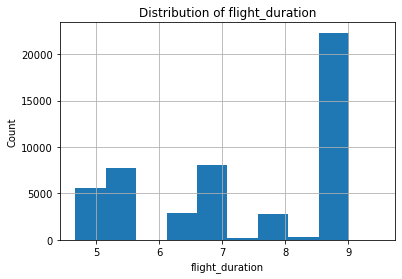

In [14]:
df["flight_duration"].hist()
plt.xlabel("flight_duration")
plt.ylabel("Count"),
plt.title("Distribution of flight_duration");

In [15]:
# Find correlation with the target and sort
correlations = df.corr()['booking_complete'].sort_values()

# Display correlations
correlations.head(20)

flight_duration         -0.106266
length_of_stay          -0.042408
purchase_lead           -0.022131
flight_hour              0.007127
num_passengers           0.024116
wants_in_flight_meals    0.026511
wants_preferred_seat     0.050116
wants_extra_baggage      0.068139
booking_complete         1.000000
Name: booking_complete, dtype: float64

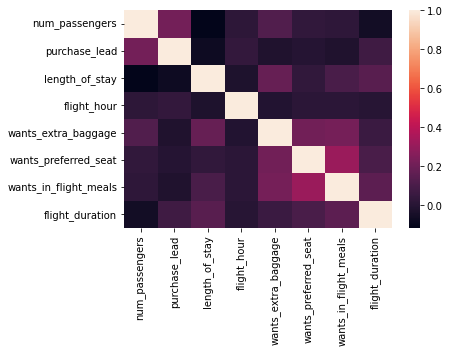

In [16]:
corr = df.drop(columns="booking_complete").corr()
sns.heatmap(corr);


In [17]:
#Create dummies/one-hot encoding on every nominal attributes in dataframe
sales_channel_dummies = pd.get_dummies(df['sales_channel'],prefix='sales_channel')
trip_type_dummies = pd.get_dummies(df['trip_type'],prefix='trip_type')
flight_day_dummies = pd.get_dummies(df['flight_day'],prefix='flight_day')
route_dummies = pd.get_dummies(df['route'],prefix='route')
booking_origin_dummies = pd.get_dummies(df['booking_origin'],prefix='booking_origin')

In [18]:
#Concate the dummies into dataset
df = pd.concat([df, sales_channel_dummies,trip_type_dummies,
                       flight_day_dummies, route_dummies, booking_origin_dummies], axis=1)

#Drop categorical attribute (before transformation)
df = df.drop(['sales_channel','trip_type','flight_day','route','booking_origin'], axis=1)

In [19]:
df.head()

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete,sales_channel_Internet,...,booking_origin_Timor-Leste,booking_origin_Tonga,booking_origin_Tunisia,booking_origin_Turkey,booking_origin_Ukraine,booking_origin_United Arab Emirates,booking_origin_United Kingdom,booking_origin_United States,booking_origin_Vanuatu,booking_origin_Vietnam
0,2,262,19,7,1,0,0,5.52,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,112,20,3,0,0,0,5.52,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2,243,22,17,1,1,0,5.52,0,1,...,0,0,0,0,0,0,0,0,0,0
3,1,96,31,4,0,0,1,5.52,0,1,...,0,0,0,0,0,0,0,0,0,0
4,2,68,22,15,1,0,1,5.52,0,1,...,0,0,0,0,0,0,0,0,0,0


## Split

In [20]:
X = df.drop(columns="booking_complete")
y = df['booking_complete']

In [21]:
# train and test split
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.3,random_state=1, stratify = y)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_val.shape)
print("y_test shape:", y_val.shape)

X_train shape: (35000, 923)
y_train shape: (35000,)
X_test shape: (15000, 923)
y_test shape: (15000,)


## 2.) BUILD MODEL

In [22]:
acc_baseline= y_train.value_counts(normalize=True).max()
print(acc_baseline)

0.8504285714285714


##### Handling imbalance data

In [23]:
Over_sampler = RandomOverSampler(random_state= 1)
X_train_over, y_train_over = Over_sampler.fit_resample(X_train,y_train)
print(X_train_over.shape)
print(y_train_over.shape)

(59530, 923)
(59530,)


In [24]:
model_cb = CatBoostClassifier(task_type='CPU', iterations=200, 
                              random_state = 400,depth=13,eval_metric="AUC")

In [25]:
model_cb.fit(X_train_over, y_train_over,  plot=True, eval_set=(X_val, y_val))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.175114
0:	test: 0.7038127	best: 0.7038127 (0)	total: 1.18s	remaining: 3m 55s
1:	test: 0.7083897	best: 0.7083897 (1)	total: 2.19s	remaining: 3m 36s
2:	test: 0.7210272	best: 0.7210272 (2)	total: 3.16s	remaining: 3m 27s
3:	test: 0.7226042	best: 0.7226042 (3)	total: 4.13s	remaining: 3m 22s
4:	test: 0.7336504	best: 0.7336504 (4)	total: 5.11s	remaining: 3m 19s
5:	test: 0.7384935	best: 0.7384935 (5)	total: 6.06s	remaining: 3m 15s
6:	test: 0.7415445	best: 0.7415445 (6)	total: 6.97s	remaining: 3m 12s
7:	test: 0.7429686	best: 0.7429686 (7)	total: 7.85s	remaining: 3m 8s
8:	test: 0.7401634	best: 0.7429686 (7)	total: 8.77s	remaining: 3m 6s
9:	test: 0.7412183	best: 0.7429686 (7)	total: 9.67s	remaining: 3m 3s
10:	test: 0.7434363	best: 0.7434363 (10)	total: 10.5s	remaining: 3m 1s
11:	test: 0.7449420	best: 0.7449420 (11)	total: 11.5s	remaining: 3m
12:	test: 0.7451512	best: 0.7451512 (12)	total: 12.4s	remaining: 2m 58s
13:	test: 0.7455939	best: 0.7455939 (13)	total: 13.3s	remainin

In [28]:
# Creating metric function 
def metrics_score(model, features, labels):
    predicted = model.predict(features)
    print(classification_report(labels, predicted))

    plot_confusion_matrix(model, features, labels)
    plt.grid(b=None)

    plt.show()

              precision    recall  f1-score   support

           0       0.85      0.76      0.80     29765
           1       0.78      0.87      0.82     29765

    accuracy                           0.81     59530
   macro avg       0.82      0.81      0.81     59530
weighted avg       0.82      0.81      0.81     59530



C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\user\AppData\Local\Temp\ipykernel_11408\1879565523.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


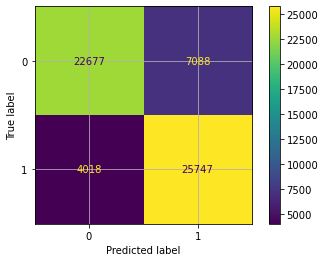

In [33]:
metrics_score(model_cb, X_train_over, y_train_over)

              precision    recall  f1-score   support

           0       0.92      0.72      0.81     12757
           1       0.29      0.63      0.40      2243

    accuracy                           0.71     15000
   macro avg       0.60      0.68      0.60     15000
weighted avg       0.82      0.71      0.75     15000



C:\Users\user\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\user\AppData\Local\Temp\ipykernel_11408\1879565523.py:7: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


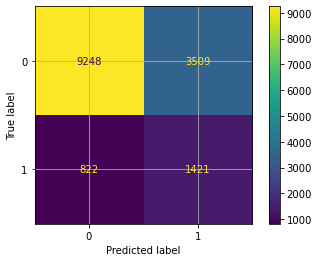

In [35]:
metrics_score(model_cb, X_val, y_val)

In [36]:
pred_prob = model_cb.predict_proba(X_val)

auc_score = roc_auc_score(y_val, pred_prob[:,1])
print(auc_score)

0.7519895277656693


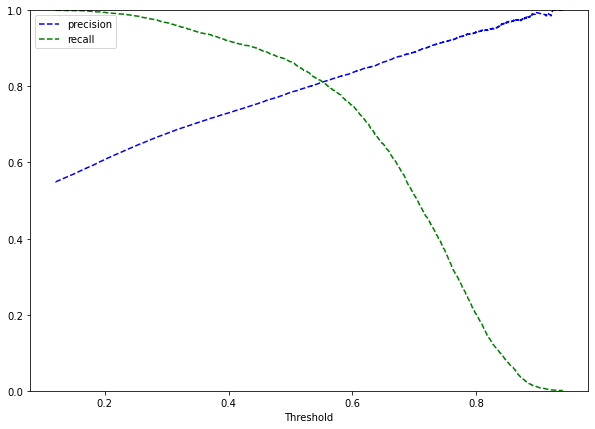

In [37]:
# Predict_proba gives the probability of each observation belonging to each class
y_scores_modelCB =model_cb.predict_proba(X_train_over)

precisions_cb, recalls_cb, thresholds_cb = precision_recall_curve(y_train_over, y_scores_modelCB[:,1])

# Plot values of precisions, recalls, and thresholds
plt.figure(figsize=(10,7))
plt.plot(thresholds_cb, precisions_cb[:-1], 'b--', label='precision')
plt.plot(thresholds_cb, recalls_cb[:-1], 'g--', label = 'recall')
plt.xlabel('Threshold')
plt.legend(loc='upper left')
plt.ylim([0,1])
plt.show()


We can see that the precison and recall are balanced for a threshold of 0.5

AUC = 0.75

## COMMUNICATE RESULT

<AxesSubplot:>

<Figure size 936x936 with 0 Axes>

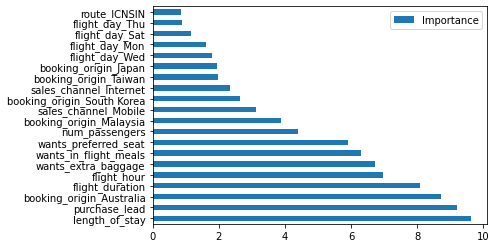

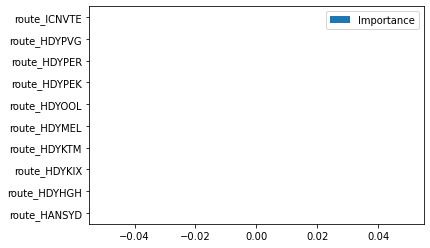

In [40]:
# Getting feature importance
importances = model_cb.feature_importances_

features = X_train_over.columns

importance_df = pd.DataFrame(importances, index = features, columns = ['Importance']).sort_values(by = 'Importance', ascending = False)

plt.figure(figsize = (13, 13))

#sns.barplot(importance_df.head(10).Importance,importance_df.index)
importance_df.head(20).plot(kind="barh")
importance_df.tail(10).plot(kind="barh")    